In [1]:
import pandas as pd
import webbrowser
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import numpy as np
import time
from selenium import webdriver
from os import listdir
import math
%matplotlib inline

In [2]:
conn = psycopg2.connect("dbname='' user='' host='localhost' password=''")
cur = conn.cursor()

In [ ]:
### Copy aggragated pitcher stats from baseballSavant.com. Manually download each year's file and name savant_data (year)

columns_null = ['pitches','player_id','player_name','total_pitches','pitch_percent','ba','iso','babip','slg',
                'woba','hits','abs','velocity','whiffs','swings','takes']
for i in range(2008,2017):
    df = pd.read_csv(r'UpdateDirectory\savant_data ().csv'.format(i))
    for column in columns_null:
        df[column] = df[column].apply(lambda x: np.nan if x == 'null' else x)
    df.dropna(subset=['pitches','player_id','player_name','total_pitches','pitch_percent','ba','iso','babip','slg',
                      'woba','hits','abs','velocity','whiffs','swings','takes'],inplace=True)
    for all_column in df.columns:
        df[all_column] = df[all_column].apply(lambda x: 0 if x == 'null' else x)
    df['year'] = i
    df.convert_objects(convert_numeric=True)
    df.to_csv('test.csv',header=False, index=False)
    df2 = open('test.csv')
    cur.copy_from(df2,"EnterDataBaseHere",sep=',',null='')
    conn.commit()

In [ ]:
### Grab the pitch data for each pitcher every year. 
for year in range(2008,2018):
    cur.execute('select player_id from pitcher where year = {}'.format(year))
    ids = cur.fetchall()
    print('year {} had {} unique pitchers'.format(year,len(ids)))
    for i in range(0,len(ids)):
        driver = webdriver.Chrome()
        driver.get('''https://baseballsavant.mlb.com/statcast_search/csv?hfPT=&hfAB=&hfBBT=&hfPR=&hfZ=&stadium=&hfBBL=&hfNewZones=&hfGT=R%7C&hfC=&hfSea={}%7C&hfSit=&player_type=pitcher&hfOuts=&opponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=&game_date_lt=&team=&position=&hfRO=&home_road=&hfFlag=&metric_1=&hfInn=&min_pitches=0&min_results=0&group_by=name&sort_col=pitches&player_event_sort=h_launch_speed&sort_order=desc&min_abs=0&type=details&player_id={}'''.format(year,ids[i][0]))
        time.sleep(1)
        driver.quit()

In [ ]:
### Process to clean the .csv file to write it to the database. 
did_not_work = []
for i in listdir():
    try:
        df = pd.read_csv('{}'.format(i))
        int_converts = ['on_2b','on_1b','on_3b']
        other_columns = [x for x in df.columns if x not in int_converts]

        for column in other_columns:
            df[column] = df[column].apply(lambda x: None if x == 'null' else x)

        for column in int_converts:
            df[column] = df[column].apply(lambda x: x.split('.')[0] if x != 'null' else None)

        df['des'] = df['des'].apply(lambda x: x.replace(',',';') if x is not None else x)

        df.to_csv('test.csv',header=False, index=False)
        df2 = open('test.csv')
        cur.copy_from(df2,"pitch",sep=',',null='')
        conn.commit()
    except:
        print('This file did not work {}'.format(i))
        did_not_work.append(i)

In [ ]:
retry_list = did_not_work

In [ ]:
### Added some functionality that works for the files that had errors. .fillna and a try and except for the int_converts. 
for i in retry_list:
    df = pd.read_csv('{}'.format(i))
    int_converts = ['on_2b','on_1b','on_3b']
    other_columns = [x for x in df.columns if x not in int_converts]

    df['des'].fillna('null', inplace=True)
    for column in other_columns:
        df[column] = df[column].apply(lambda x: None if x == 'null' else x)

    for column in int_converts:
        try:
            df[column] = df[column].apply(lambda x: x.split('.')[0] if x != 'null' else None)
        except:
            df[column] = df[column].apply(lambda x: int(str(x).split('.')[0]) if x != 'null' else None)

    df['des'] = df['des'].apply(lambda x: x.replace(',',';') if x is not None else x)

    df.to_csv('test.csv',header=False, index=False)
    df2 = open('test.csv')
    cur.copy_from(df2,"pitch",sep=',',null='')
    conn.commit()
    print('This file now works {}'.format(i))
    retry_list.pop(retry_list.index(i))

In [3]:
testdf = pd.read_sql('select * from pitch where game_year = 2017;',conn)

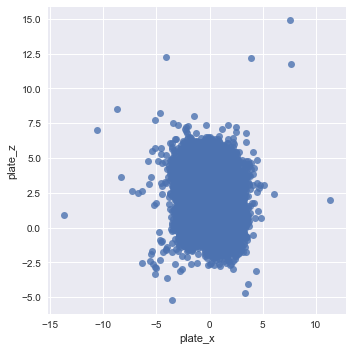

In [4]:
sns.lmplot(x='plate_x',y='plate_z',data=testdf,fit_reg=False)

In [5]:
### Creation of the average distance from edge of strike zone variable. 

l = len(testdf.index.values)
for i in range(0,l):
    pitch_distance = []
    pitch_x = testdf.loc[i,'plate_x']
    pitch_y = testdf.loc[i,'plate_z']
#     print(pitch_x,pitch_y)
    
    #calc distance from top and bottome
    pitch_distance.append(abs(pitch_y-1.74))
    pitch_distance.append(abs(pitch_y-3.42))
    
    #calc distance from sides
    pitch_distance.append(abs(pitch_x-.708))
    pitch_distance.append(abs(pitch_x-(-.708)))
    
#     print(pitch_distance)
    
    min_distance = min(pitch_distance)
#     print(min(pitch_distance))
    
    testdf.loc[i,'pfx_fromedge'] = min_distance
    
    if i % 1000 == 0:
        print(i)
    
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [6]:
pfx_average = testdf.groupby('player_name', as_index=False)['pfx_fromedge'].mean()

In [7]:
pfx_average['player_name'] = pfx_average['player_name'].apply(lambda x: x.strip())

In [8]:
pitcherdf = pd.read_sql('select * from pitcher where year = 2017;',conn)

In [9]:
analyze_df = pd.merge(pitcherdf, pfx_average, on='player_name')

In [10]:
analyze_df[['ba','pfx_fromedge','iso','slg','hits']].corr()

,ba,pfx_fromedge,iso,slg,hits
ba,1.000000,-0.034640,0.450077,0.816373,-0.092106
pfx_fromedge,-0.034640,1.000000,0.052471,0.015702,-0.079246
iso,0.450077,0.052471,1.000000,0.883149,-0.077039
slg,0.816373,0.015702,0.883149,1.000000,-0.098121
hits,-0.092106,-0.079246,-0.077039,-0.098121,1.000000


In [ ]:
cur.close()
conn.close()

In [ ]:
df_creator = 0 
for i in listdir():
    try:
        if df_creator == 0:
            all_pitch = pd.read_csv('{}'.format(i))
            print(all_pitch.head)
            df_creator += 1
        else:
            all_pitch = all_pitch.append(pd.read_csv('{}'.format(i)))
    except:
        print('{}'.format)

In [12]:
analyze_df.to_csv('analyze_df.csv',index=False)

In [15]:
all_pitch.to_csv('allpitch.csv',index=False)

In [ ]:
analyze_df.head()